In [44]:
library(tidyverse)  # data manipulation
library(cluster)    # clustering algorithms
library(factoextra) # clustering algorithms & visualization
library(dtwclust)
library(lubridate)
library("RColorBrewer")
library(gplots)


Attaching package: ‘gplots’

The following object is masked from ‘package:stats’:

    lowess



## Dtwclust

### Compute CVI & Compare

In [2]:
types<-c("partitional", "hierarchical", "tadpole","fuzzy")
dists<-c("dtw_lb","lbk","lbi","sbd","gak","sdtw")
for (file in list.files('./datasets2')){
    print(file)
    for (dist in dists){
        df <- read_csv(file.path('./datasets2/',file))
        pc <- tsclust(df, type = "partitional", k = 3L:7L, 
                   distance = dist, centroid = "pam", 
                   seed = 3247L, trace = TRUE, args = tsclust_args(dist = list(window.size = 5L)))
        names(pc) <-paste0("k_", 3L:7L)
        pc_cvi<-sapply(pc,cvi, type="internal")
        print(pc_cvi)
        write.csv(pc_cvi, paste0('cvi/partitional/',dist,'/',file))
        df <- NULL
        pc <- NULL
        pc_cvi <-NULL
    }
}

[1] "90_0.75.csv"


Parsed with column specification:
cols(
  `0` = col_double(),
  `1` = col_double(),
  `2` = col_double(),
  `3` = col_double(),
  `4` = col_double(),
  `5` = col_double(),
  `6` = col_double()
)
Warning message in pam_distmat(series, control, distance, cent_char, family, args, :
“Using dtw_lb with control$pam.precompute = TRUE is not advised.”

### CVI plot 

In [ ]:
cvis<-list()
file_head='/Users/wang/work/bgprophet/libre/cvi'
for (file in list.files(file_head)){
  print(file)
  cvi <- read_csv(file.path(file_head,file))
  
  cvi[3,2:6] <- cvi[3,2:6]/10000 # normalize CH values
  
  df<-melt(cvi)
  names(df) <- c('metrics', 'cluster_num', 'value')
  print(df)
  pl=
    ggplot(df, aes(cluster_num, value, group=factor(metrics)))+
    geom_line(aes(color=factor(metrics)))+
    labs(title=gsub('.csv','',file))
  
  cvis[[file]]<-pl
}
ggarrange(plotlist = cvis)
grobs<-arrangeGrob(cvis, nrow = 2)
ggsave('cvis.pdf', grobs)


## Kmeans 

In [ ]:
k6 <- kmeans(df_raw, centers = 6, nstart = 25)


Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine



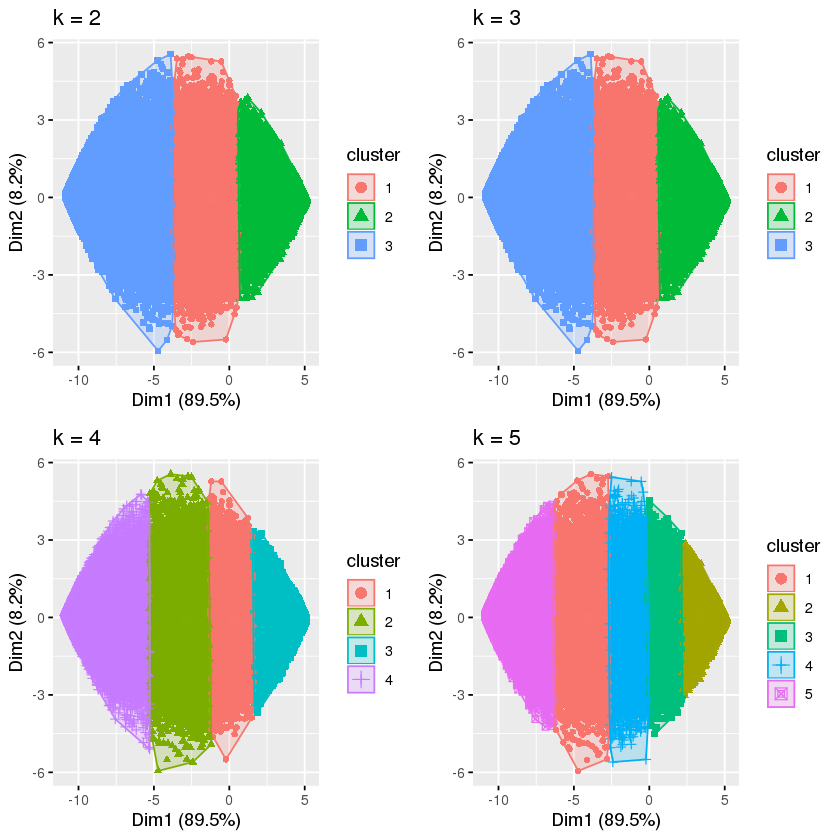

In [35]:
df=df_raw
k3 <- kmeans(df, centers = 3, nstart = 25)
k4 <- kmeans(df, centers = 4, nstart = 25)
k5 <- kmeans(df, centers = 5, nstart = 25)

# plots to compare
p1 <- fviz_cluster(k2, geom = "point", data = df) + ggtitle("k = 2")
p2 <- fviz_cluster(k3, geom = "point",  data = df) + ggtitle("k = 3")
p3 <- fviz_cluster(k4, geom = "point",  data = df) + ggtitle("k = 4")
p4 <- fviz_cluster(k5, geom = "point",  data = df) + ggtitle("k = 5")

library(gridExtra)
grid.arrange(p1, p2, p3, p4, nrow = 2)

## Evaluation methods

### Elbow method

In [ ]:
set.seed(123)

# function to compute total within-cluster sum of square 
wss <- function(k) {
  kmeans(df, k, nstart = 10 )$tot.withinss
}

# Compute and plot wss for k = 1 to k = 15
k.values <- 1:15

# extract wss for 2-15 clusters
wss_values <- map_dbl(k.values, wss)

plot(k.values, wss_values,
       type="b", pch = 19, frame = FALSE, 
       xlab="Number of clusters K",
       ylab="Total within-clusters sum of squares")

### Average Silhouette Method

In [9]:
# function to compute average silhouette for k clusters
avg_sil <- function(k) {
  km.res <- kmeans(df, centers = k, nstart = 25)
  ss <- silhouette(km.res$cluster, dist(df))
  mean(ss[, 3])
}

# Compute and plot wss for k = 2 to k = 15
k.values <- 2:15

# extract avg silhouette for 2-15 clusters
avg_sil_values <- map_dbl(k.values, avg_sil)

plot(k.values, avg_sil_values,
       type = "b", pch = 19, frame = FALSE, 
       xlab = "Number of clusters K",
       ylab = "Average Silhouettes")

ERROR: Error: cannot allocate vector of size 158.3 Gb


## Using compare_clustering

In [5]:
# Fuzzy preprocessing: calculate autocorrelation up to 50th lag
acf_fun <- function(series, ...) {
    lapply(series, function(x) {
        as.numeric(acf(x, lag.max = 50, plot = FALSE)$acf)
    })
}

# Define overall configuration
cfgs <- compare_clusterings_configs(
    types = c("p", "h", "f", "t"),
    k = 19L:20L,
    controls = list(
        partitional = partitional_control(
            iter.max = 30L,
            nrep = 1L
        ),
        hierarchical = hierarchical_control(
            method = "all"
        ),
        fuzzy = fuzzy_control(
            # notice the vector
            fuzziness = c(2, 2.5),
            iter.max = 30L
        ),
        tadpole = tadpole_control(
            # notice the vectors
            dc = c(1.5, 2),
            window.size = 19L:20L
        )
    ),
    preprocs = pdc_configs(
        type = "preproc",
        # shared
        none = list(),
        zscore = list(center = c(FALSE)),
        # only for fuzzy
        fuzzy = list(
            acf_fun = list()
        ),
        # only for tadpole
        tadpole = list(
            reinterpolate = list(new.length = 205L)
        ),
        # specify which should consider the shared ones
        share.config = c("p", "h")
    ),
    distances = pdc_configs(
        type = "distance",
        sbd = list(),
        fuzzy = list(
            L2 = list()
        ),
        share.config = c("p", "h")
    ),
    centroids = pdc_configs(
        type = "centroid",
        partitional = list(
            pam = list()
        ),
        # special name 'default'
        hierarchical = list(
            default = list()
        ),
        fuzzy = list(
            fcmdd = list()
        ),
        tadpole = list(
            default = list(),
            shape_extraction = list(znorm = TRUE)
        )
    )
)

# Number of configurations is returned as attribute
num_configs <- sapply(cfgs, attr, which = "num.configs")
cat("\nTotal number of configurations without considering optimizations:",
    sum(num_configs),
    "\n\n")


# Define evaluation functions based on CVI: Variation of Information (only crisp partition)
# vi_evaluators <- cvi_evaluators("VI")
# score_fun <- vi_evaluators$score
# pick_fun <- vi_evaluators$pick


Total number of configurations without considering optimizations: 56 



### Clustering on one case

In [54]:
library(tibbletime)
library(dplyr)


Attaching package: ‘tibbletime’

The following object is masked from ‘package:stats’:

    filter



In [57]:
case1 <- read.csv('../data/libre_clean/1Chloe AliceEtherington_glucose_5-8-2019.csv')

In [64]:
head(case1)

time,bg,No
<dttm>,<dbl>,<int>
2019-01-30 15:26:00,NA,1
2019-01-30 16:26:00,13.5,1
2019-01-30 16:26:00,NA,1
2019-01-30 16:26:00,NA,1
2019-01-30 16:28:00,13.9,1
2019-01-30 16:36:00,14.4,1


In [63]:
case1$time <- as.POSIXct(case1$time)

In [71]:
for (file in list.files('../data/libre_clean/')){
    case <- read.csv(file.path('../data/libre_clean/',file))
    case$time <- as.POSIXct(case$time)
    ggplot(data=case) + geom_line(mapping = aes(x=time, y=bg)) + labs(title = file)  
}

In [125]:
file = '3JohnValentine_glucose_5-8-2019.csv'
case <- read.csv(file.path('../data/libre_clean/',file))
case$time <- as.POSIXct(case$time)

## Case study, windows = 150min, case numbers= 20

In [24]:
df_all <- read_csv(file.path('./datasets4/dfs_p_150_0.csv')) 

Parsed with column specification:
cols(
  `0` = col_double(),
  `1` = col_datetime(format = ""),
  `2` = col_double(),
  `3` = col_double(),
  `4` = col_double(),
  `5` = col_double(),
  `6` = col_double(),
  `7` = col_double(),
  `8` = col_double(),
  `9` = col_double(),
  `10` = col_double(),
  `11` = col_double(),
  `12` = col_double()
)


In [25]:
df <- df_all %>% select(3:13)
# df <- read_csv(file.path('./datasets3/90_0.csv'))
pc <- tsclust(df, type = "partitional", k = 3L:7L, 
           distance = "sdtw", centroid = "pam", 
           seed = 3247L, trace = TRUE)
names(pc) <-paste0("k_", 3L:7L)


	Precomputing distance matrix...



Repetition 1 for k = 3


Iteration 1: Changes / Distsum = 7451 / 567660.2
Iteration 2: Changes / Distsum = 389 / 300624.9
Iteration 3: Changes / Distsum = 151 / 296381.4
Iteration 4: Changes / Distsum = 0 / 296381.4



Repetition 1 for k = 4


Iteration 1: Changes / Distsum = 7451 / 723495.7
Iteration 2: Changes / Distsum = 1301 / 312207.2
Iteration 3: Changes / Distsum = 855 / 257459.5
Iteration 4: Changes / Distsum = 433 / 244217.8
Iteration 5: Changes / Distsum = 483 / 236720.4
Iteration 6: Changes / Distsum = 458 / 226451
Iteration 7: Changes / Distsum =   0 / 226451



Repetition 1 for k = 5


Iteration 1: Changes / Distsum = 7451 / 440253.7
Iteration 2: Changes / Distsum = 1867 / 239936.8
Iteration 3: Changes / Distsum = 875 / 212170.1
Iteration 4: Changes / Distsum = 426 / 200194.6
Iteration 5: Changes / Distsum = 270 / 197645.9
Iteration 6: Changes / Distsum = 0 / 197645.9



Repetition 1 for k = 6


Iteration 1: Changes / Distsum = 7451 / 465108.8
Iteration 2: Changes / Distsum = 1564 / 266654.2
Iteration 3: Changes / Distsum = 943 / 217886.7
Iteration 4: Changes / Distsum = 890 / 189335.9
Iteration 5: Changes / Distsum = 524 / 183440.2
Iteration 6: Changes / Distsum = 461 / 178680.9
Iteration 7: Changes / Distsum = 162 / 177890.3
Iteration 8: Changes / Distsum = 184 / 177295.4
Iteration 9: Changes / Distsum = 167 / 175927.2
Iteration 10: Changes / Distsum = 0 / 175927.2



Repetition 1 for k = 7


Iteration 1: Changes / Distsum = 7451 / 312280
Iteration 2: Changes / Distsum = 1208 / 166013.8
Iteration 3: Changes / Distsum = 924 / 151453.4
Iteration 4: Changes / Distsum = 418 / 146907.8
Iteration 5: Changes / Distsum = 140 / 146051.5
Iteration 6: Changes / Distsum = 0 / 146051.5

	Elapsed time is 18.12 seconds.



In [26]:
df_clust <- df_all %>% mutate(k_3=pc$k_3@cluster, k_4=pc$k_4@cluster, k_5=pc$k_5@cluster, k_6=pc$k_6@cluster, k_7=pc$k_7@cluster)

In [28]:
names(df_clust) <- c('No', 'time', '1','2','3','4','5','6','7','8', '9','10', '11', 'k_3', 'k_4', 'k_5', 'k_6', 'k_7')

In [29]:
centroids <-tibble(pc$k_6@centroids)

In [30]:

z1<-data.frame(x=1L:11L, y=pc$k_6@centroids[1])
names(z1) <- c('x', 'y')
cc1 <- ggplot(z1, aes(x, y)) +geom_line() + ggtitle('k_1')

z2<-data.frame(x=1L:11L, y=pc$k_6@centroids[2])
names(z2) <- c('x', 'y')
cc2 <- ggplot(z2, aes(x, y)) +geom_line() + ggtitle('k_2')

z3<-data.frame(x=1L:11L, y=pc$k_6@centroids[3])
names(z3) <- c('x', 'y')
cc3 <- ggplot(z3, aes(x, y)) +geom_line() + ggtitle('k_3')

z4<-data.frame(x=1L:11L, y=pc$k_6@centroids[4])
names(z4) <- c('x', 'y')
cc4 <- ggplot(z4, aes(x, y)) +geom_line() + ggtitle('k_4')

z5<-data.frame(x=1L:11L, y=pc$k_6@centroids[5])
names(z5) <- c('x', 'y')
cc5 <- ggplot(z5, aes(x, y)) +geom_line() + ggtitle('k_5')

z6<-data.frame(x=1L:11L, y=pc$k_6@centroids[6])
names(z6) <- c('x', 'y')
cc6 <- ggplot(z6, aes(x, y)) +geom_line() + ggtitle('k_6')

# ccs <- list()
# for (i in 1L:6L){
#     z<-data.frame(x=1L:7L, y=pc$k_6@centroids[i])
#     names(z) <- c('x', 'y')
#     cc <- ggplot(z, aes(x, y)) +geom_line() + ggtitle(i)
#     ccs[i]<-cc
# }


Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine

Saving 6.67 x 6.67 in image


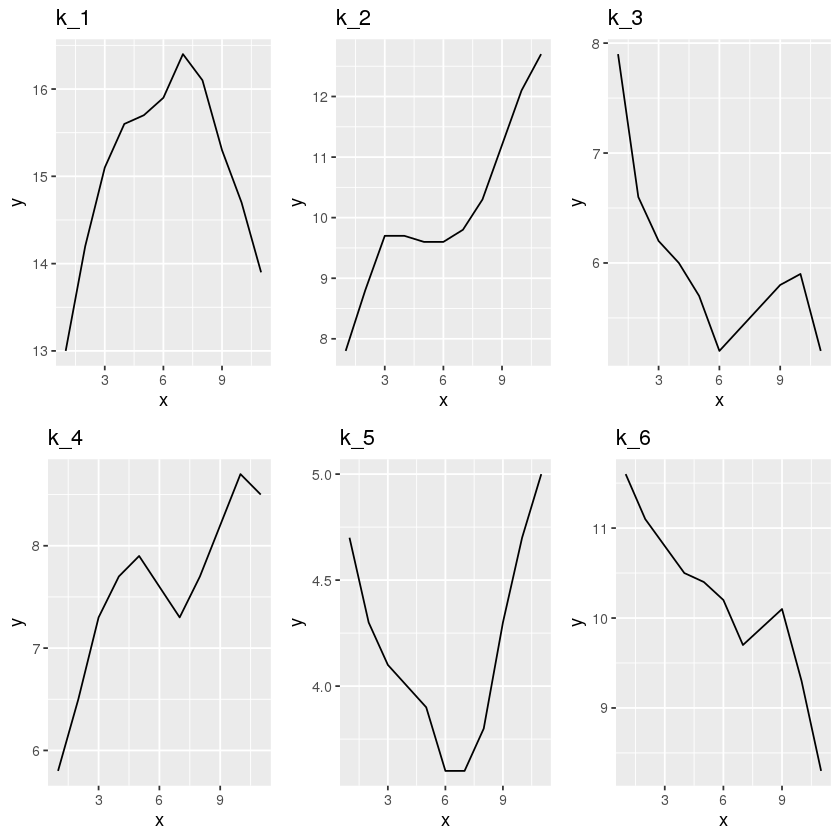

In [31]:
library(gridExtra)
# plots = mget(cc1,cc2,cc3,cc4,cc5,cc6)
grid.arrange(cc1,cc2,cc3,cc4,cc5,cc6, nrow = 2)
grobs<-arrangeGrob(cc1,cc2,cc3,cc4,cc5,cc6, nrow = 2)
ggsave('centroids_150.pdf', grobs)

Saving 6.67 x 6.67 in image


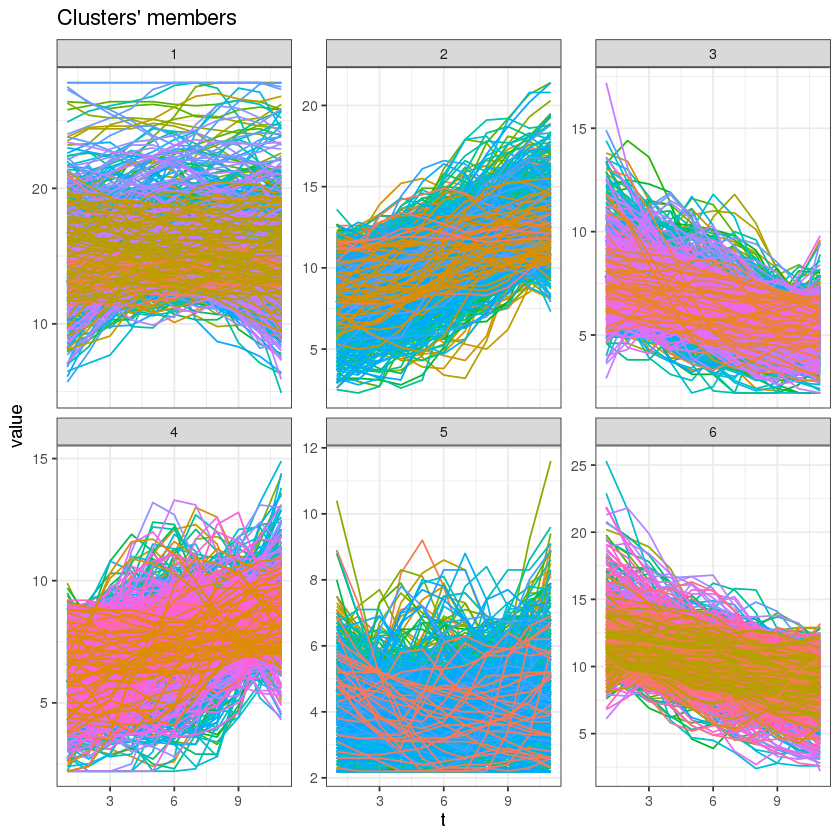

In [32]:
plot(pc$k_6)
ggsave('all_clusters_variations_150.pdf')

In [33]:
tally_clust <- df_clust %>% group_by(No, k_6) %>% tally() %>% spread(k_6, n)

In [36]:
tally_clust[2:7]

1,2,3,4,5,6
<int>,<int>,<int>,<int>,<int>,<int>
189,113,36,82,4,191
96,61,76,92,43,103
313,289,311,356,174,373
85,46,27,31,6,69
26,38,40,43,30,52
20,24,33,27,22,39
91,59,14,26,3,90
2,2,76,24,28,12
96,106,92,118,42,184


In [60]:
pdf(file="heatmap-20instances_150.pdf")
heatmap_data = as.matrix(tally_clust[2:7])
heatmap.2(heatmap_data,dendrogram ='row',scale='row',density.info = 'none',
        xlab = 'specification variations', 
        ylab='Instance number')
dev.off()

png 
  2

In [446]:
tally_clust %>% spread(k_5, n)

No,1,2,3,4,5
<dbl>,<int>,<int>,<int>,<int>,<int>
1,603,11,260,334,103
2,297,152,265,195,225
3,1130,394,963,679,892
4,186,18,129,170,77
5,142,84,130,63,101
6,103,70,77,43,77
7,255,7,121,192,58
8,29,68,72,2,246
9,430,117,375,214,313


## Picked case visualization for windows=90mins 

In [ ]:
time_all <- read_csv(file.path('./datasets4/times_all_case3.csv')) 

In [485]:
df_clust_3_gathered <-
df_clust %>% 
filter(No==3) %>%
gather('1','2','3','4','5','6','7', key='sub_index', value='bg') %>%
mutate(time_all=times_all$'0')
# pc$k_3@cluster

In [486]:
head(df_clust_3_gathered)

No,time,k_3,k_4,k_5,k_6,k_7,sub_index,bg,time_all
<dbl>,<dttm>,<int>,<int>,<int>,<int>,<int>,<chr>,<dbl>,<dttm>
3,2018-02-14 18:48:00,1,2,5,1,7,1,6.8,2018-02-14 18:48:00
3,2018-02-14 19:20:00,2,2,5,4,2,1,7.7,2018-02-14 19:03:00
3,2018-02-14 20:05:00,2,4,5,5,6,1,5.7,2018-02-14 19:18:00
3,2018-02-14 20:48:00,1,2,3,4,5,1,10.6,2018-02-14 19:33:00
3,2018-02-15 01:07:00,2,2,5,1,7,1,4.8,2018-02-14 19:48:00
3,2018-02-15 06:39:00,3,3,4,6,3,1,16.0,2018-02-14 20:03:00


In [488]:
df_clust_3_gathered_one_day = filter(df_clust_3_gathered, time_all > '2019-01-01' & time_all<'2019-01-02')

In [489]:
df_clust_3_gathered_one_week = filter(df_clust_3_gathered, time_all > '2019-01-01' & time_all<'2019-01-08')

In [111]:
cluster_visual <- function(dataset, title){

    myPalette <- colorRampPalette(rev(brewer.pal(8, "Accent")))
    sc <- scale_colour_gradientn(colours = myPalette(100), limits=c(1, 8))

    ggplot()+
    geom_line(data=dataset,mapping = aes(x=time_all, y=bg, color = k_6), size=2)+
    sc+
    labs(title = title)  

    ggsave(title, width = 20, height = 10,limitsize = FALSE)
}

In [495]:
cluster_visual(df_clust_3_gathered_one_day, 'case3_one_day.pdf')

In [496]:
cluster_visual(df_clust_3_gathered_one_week, 'case3_one_week.pdf')

## Picked case visualization for windows=150mins 

In [4]:
df_all_150 <- read_csv(file.path('./datasets4/dfs_p_150_0.csv')) 
names(df_all_150) <- c('No', 'time', '1','2','3','4','5','6','7','8','9','10','11')

Parsed with column specification:
cols(
  `0` = col_double(),
  `1` = col_datetime(format = ""),
  `2` = col_double(),
  `3` = col_double(),
  `4` = col_double(),
  `5` = col_double(),
  `6` = col_double(),
  `7` = col_double(),
  `8` = col_double(),
  `9` = col_double(),
  `10` = col_double(),
  `11` = col_double(),
  `12` = col_double()
)


In [ ]:
df <- df_all_150 %>% select(3:13)
pc <- tsclust(df, type = "partitional", k = 3L:7L, 
           distance = "sdtw", centroid = "pam", 
           seed = 3247L, trace = TRUE)

In [6]:
names(pc) <-paste0("k_", 3L:7L)

In [66]:
times_all_150 <- read_csv(file.path('./datasets4/times_all_150_0_3.csv')) 

Warning message:
“Missing column names filled in: 'X1' [1]”Parsed with column specification:
cols(
  X1 = col_double(),
  `0` = col_datetime(format = "")
)


In [83]:
df_clust_3 <- df_all_150 %>% 
mutate(k_3=pc$k_3@cluster, k_4=pc$k_4@cluster, k_5=pc$k_5@cluster, k_6=pc$k_6@cluster, k_7=pc$k_7@cluster) %>%
filter(No==3)

In [ ]:
df_clust_3

In [105]:
df_clust_3 <-
df_all_150 %>% 
mutate(k_3=pc$k_3@cluster, k_4=pc$k_4@cluster, k_5=pc$k_5@cluster, k_6=pc$k_6@cluster, k_7=pc$k_7@cluster) %>%
filter(No==3) %>%
gather('1','2','3','4','5','6','7','8','9','10','11', key='sub_index', value='bg') %>% 
# filter(time == '2018-02-14 19:20:00') %>%
arrange(time) %>%
mutate(time_all=times_all_150$'0')

In [106]:
df_clust_3

No,time,k_3,k_4,k_5,k_6,k_7,sub_index,bg,time_all
<dbl>,<dttm>,<int>,<int>,<int>,<int>,<int>,<chr>,<dbl>,<dttm>
3,2018-02-14 19:20:00,1,2,1,3,2,1,5.8,2018-02-14 19:20:00
3,2018-02-14 19:20:00,1,2,1,3,2,2,7.0,2018-02-14 19:35:00
3,2018-02-14 19:20:00,1,2,1,3,2,3,7.9,2018-02-14 19:50:00
3,2018-02-14 19:20:00,1,2,1,3,2,4,8.1,2018-02-14 20:05:00
3,2018-02-14 19:20:00,1,2,1,3,2,5,7.7,2018-02-14 20:20:00
3,2018-02-14 19:20:00,1,2,1,3,2,6,6.9,2018-02-14 20:35:00
3,2018-02-14 19:20:00,1,2,1,3,2,7,6.1,2018-02-14 20:50:00
3,2018-02-14 19:20:00,1,2,1,3,2,8,5.7,2018-02-14 21:05:00
3,2018-02-14 19:20:00,1,2,1,3,2,9,5.5,2018-02-14 21:20:00


In [123]:
df_clust_3_one_day = filter(df_clust_3, time_all > '2019-02-16' & time_all<'2019-02-17')
cluster_visual(df_clust_3_one_day, 'case3_one_day_window150_case3_cluster6.pdf')

In [121]:
df_clust_3_one_week = filter(df_clust_3, time_all > '2019-02-14' & time_all<'2019-02-21')
cluster_visual(df_clust_3_one_week, 'case3_one_week_window150_case3_cluster6.pdf')